In [4]:
import csv
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns

from sklearn.preprocessing import StandardScaler, OrdinalEncoder

from constants import *

# Embeds graphs in Jupyter notebook (instead of pop-ups)
%matplotlib inline

# pd.set_option('display.max_columns', None) # show all columns

In [3]:
main_df = pd.read_csv('./data/teams/teams.csv')

In [4]:
# Normalize data so features have same scale, such that the model will not
# give different weights to different features based on their range
# Only team name has values of type string; rest are numeric

# all non-numeric encoded, then all columns scaled to normal distribution

excluded_cols = ['season_start_year', 'season_end_year', 'squad']

scaler = StandardScaler()
encoder = OrdinalEncoder()
        
df_excluded = main_df.drop(columns=excluded_cols)
df_non_numeric = df_excluded.select_dtypes(exclude=[np.number])
df_numeric = df_excluded.select_dtypes(include=[np.number])

encoded_df = pd.DataFrame(
    encoder.fit_transform(df_non_numeric),
    columns=df_non_numeric.columns,
    index=main_df.index
)
encoded_df = pd.concat([encoded_df, df_numeric], axis=1)

scaled_df = pd.DataFrame(
    scaler.fit_transform(encoded_df),
    columns=encoded_df.columns,
    index=main_df.index
)
pd.DataFrame(pd.concat([scaled_df, main_df[excluded_cols]], axis=1)) \
    .to_csv(f"./data/machine_learning/train_teams.csv",index=False)

In [5]:
encoded_df = pd.read_csv(f"./data/machine_learning/train_teams.csv", encoding='utf-8')
scores_df = pd.read_csv(f"./data/scores/scores.csv", encoding='utf-8')

In [6]:
encoded_df

,minutes,gk_minutes,players_used,avg_age,possession,games,games_starts,minutes_90s,goals,assists,...,pens_won,pens_conceded,own_goals,ball_recoveries,aerials_won,aerials_lost,aerials_won_pct,season_start_year,season_end_year,squad
0,0.419855,0.451688,-0.073473,0.108418,1.089131,0.265223,0.269349,0.269349,0.997358,1.189655,...,-0.278804,0.448111,-0.355649,0.082032,-0.283964,0.353212,-1.254362,2018,2019,Arsenal
1,0.419855,0.451688,-0.073473,0.021541,-0.714078,0.265223,0.269349,0.269349,0.090524,0.457457,...,1.289567,-0.298231,1.379918,-0.403201,0.730266,1.031771,-0.548405,2018,2019,Bournemouth
2,0.419855,0.451688,-2.200467,0.716553,-1.438582,0.265223,0.269349,0.269349,-1.204953,-1.088294,...,0.113289,1.567625,-1.223433,-0.031189,1.584719,1.333352,0.285907,2018,2019,Brighton
3,0.419855,0.451688,-1.592755,1.237812,-1.631783,0.265223,0.269349,0.269349,-0.686762,-0.437452,...,-1.455081,-1.044573,2.247702,-0.160584,2.918500,3.012613,-0.227516,2018,2019,Burnley
4,0.419855,0.451688,-1.288899,0.629676,1.861935,0.265223,0.269349,0.269349,0.479167,1.189655,...,0.113289,-1.417744,-1.223433,1.003976,-0.506261,-0.558386,0.125463,2018,2019,Chelsea
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
483,0.419855,0.451688,1.141952,-1.194729,0.654429,0.265223,0.269349,0.269349,0.803037,0.782878,...,-0.670896,-0.298231,-0.355649,0.270734,-0.402059,-0.448720,0.125463,2022,2023,Rennes
484,0.419855,0.451688,0.230383,0.629676,-0.875079,0.265223,0.269349,0.269349,-0.362893,-0.762873,...,0.505382,1.940796,-1.223433,0.793708,0.563543,-0.085452,1.184398,2022,2023,Strasbourg
485,0.419855,0.451688,0.230383,-1.281606,-0.005675,0.265223,0.269349,0.269349,-0.233345,-0.356096,...,-1.062989,0.448111,1.379918,0.987801,-0.784132,-0.859968,0.221729,2022,2023,Toulouse
486,0.419855,0.451688,2.053521,-1.194729,0.702729,0.265223,0.269349,0.269349,-0.686762,-0.437452,...,1.289567,-1.790916,0.512135,1.435294,0.042535,-0.297930,0.670975,2022,2023,Le Havre


In [7]:
encoded_df["avg_age"]

0      0.108418
1      0.021541
2      0.716553
3      1.237812
4      0.629676
         ...   
483   -1.194729
484    0.629676
485   -1.281606
486   -1.194729
487   -0.934100
Name: avg_age, Length: 488, dtype: float64

In [8]:
encoded_df.groupby('season_start_year').squad.count().unique()

array([98, 96])

In [9]:
print(f"Initial Dataframe is {len(scores_df)} rows")

home_df = scores_df.copy()
away_df = scores_df.copy()

home_df['time'] = home_df['time']
home_df['team'] = home_df['home_team']
home_df['opponent'] = home_df['away_team']
home_df['is_home'] = 1
home_df['score'] = home_df['home_score']
home_df['opponent_score'] = home_df['away_score']

away_df['time'] = away_df['time']
away_df['team'] = away_df['away_team']
away_df['opponent'] = away_df['home_team']
away_df['is_home'] = 0
away_df['score'] = away_df['away_score']
away_df['opponent_score'] = away_df['home_score']

final_scores_df = pd.concat([home_df, away_df], ignore_index=True)

# Selecting the relevant columns for the new dataframe
final_scores_df = final_scores_df[['time','team', 'opponent', 'is_home', 'score', 'opponent_score', 'season_start_year', 'season_end_year']]

final_scores_df

Initial Dataframe is 8533 rows


,time,team,opponent,is_home,score,opponent_score,season_start_year,season_end_year
0,2019-06-18 01:00:00,Aston Villa,Sheffield Utd,1,0,0,2019,2020
1,2019-06-18 03:15:00,Manchester City,Arsenal,1,3,0,2019,2020
2,2019-06-20 01:00:00,Norwich,Southampton,1,0,3,2019,2020
3,2019-06-20 03:15:00,Tottenham,Manchester Utd,1,1,1,2019,2020
4,2019-06-20 19:30:00,Watford,Leicester,1,1,1,2019,2020
...,...,...,...,...,...,...,...,...
17061,2024-03-17 22:00:00,Metz,Reims,0,1,2,2023,2024
17062,2024-03-17 22:00:00,Lorient,Monaco,0,2,2,2023,2024
17063,2024-03-17 22:00:00,Le Havre,Clermont,0,1,2,2023,2024
17064,2024-03-18 00:05:00,Marseille,Rennes,0,0,2,2023,2024


In [10]:
teams_perf_df = encoded_df.add_prefix('team_')
teams_vs_perf_df = encoded_df.add_prefix('opponent_')

extended_df = pd.merge(final_scores_df, teams_perf_df, how='left', left_on=['team', 'season_start_year'], right_on=['team_squad', 'team_season_end_year'])
extended_df = pd.merge(extended_df, teams_vs_perf_df, how='left', left_on=['opponent', 'season_start_year'], right_on=['opponent_squad', 'opponent_season_end_year'])
extended_df.shape

(17066, 370)

In [11]:
print(f'Original Performance DF has {len(encoded_df.columns)} columns')
print(f'Original Scores DF has {len(final_scores_df.columns)} columns')
print(f'Final Dataframe should have {len(encoded_df.columns) * 2 + len(final_scores_df.columns)} columns')
print(f'Final Dataframe has {len(extended_df.columns)} columns')

Original Performance DF has 181 columns
Original Scores DF has 8 columns
Final Dataframe should have 370 columns
Final Dataframe has 370 columns


In [12]:
df_sorted = extended_df.sort_values(by=['season_start_year', 'team', 'time'])
df_sorted

,time,team,opponent,is_home,score,opponent_score,season_start_year,season_end_year,team_minutes,team_gk_minutes,...,opponent_pens_won,opponent_pens_conceded,opponent_own_goals,opponent_ball_recoveries,opponent_aerials_won,opponent_aerials_lost,opponent_aerials_won_pct,opponent_season_start_year,opponent_season_end_year,opponent_squad
12149,2019-06-23 01:30:00,AC Milan,Lecce,0,4,1,2019,2020,0.419855,0.451688,...,-1.062989,-0.671402,-1.223433,-1.556978,-0.603515,-0.976488,0.959775,2018,2019,Lecce
3630,2019-06-28 23:15:00,AC Milan,AS Roma,1,2,0,2019,2020,0.419855,0.451688,...,0.113289,0.448111,-0.355649,-0.165976,0.910882,-0.263659,2.114978,2018,2019,AS Roma
12176,2019-07-02 03:45:00,AC Milan,Spal,0,2,2,2019,2020,0.419855,0.451688,...,0.897474,-0.298231,-1.223433,-1.147226,-0.186709,-0.058035,-0.259605,2018,2019,Spal
12181,2019-07-05 03:45:00,AC Milan,Lazio,0,3,0,2019,2020,0.419855,0.451688,...,-0.670896,0.074940,1.379918,0.685878,0.112003,-0.318492,0.863508,2018,2019,Lazio
3657,2019-07-08 03:45:00,AC Milan,Juventus,1,4,2,2019,2020,0.419855,0.451688,...,0.113289,-0.671402,-0.355649,-0.209108,-0.429846,-0.798281,0.863508,2018,2019,Juventus
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1752,2024-02-10 23:00:00,Wolves,Brentford,1,0,2,2023,2024,0.419855,0.451688,...,0.897474,-1.417744,1.379918,-0.139019,0.480182,0.222984,0.414263,2022,2023,Brentford
10295,2024-02-17 23:00:00,Wolves,Tottenham,0,2,1,2023,2024,0.419855,0.451688,...,0.113289,-0.671402,-0.355649,-0.004231,-0.325644,-0.764010,1.023953,2022,2023,Tottenham
1776,2024-02-25 21:30:00,Wolves,Sheffield Utd,1,1,0,2023,2024,0.419855,0.451688,...,-1.062989,-0.671402,-0.355649,3.489449,2.564215,2.265513,0.253818,2022,2023,Sheffield Utd
10312,2024-03-02 23:00:00,Wolves,Newcastle,0,0,3,2023,2024,0.419855,0.451688,...,-1.062989,-0.298231,0.512135,0.432479,-0.297857,-1.086154,1.890355,2022,2023,Newcastle


In [13]:
extended_df.loc[(extended_df['team'] == 'Heidenheim') & (extended_df['opponent'] == 'Werder Bremen')]

,time,team,opponent,is_home,score,opponent_score,season_start_year,season_end_year,team_minutes,team_gk_minutes,...,opponent_pens_won,opponent_pens_conceded,opponent_own_goals,opponent_ball_recoveries,opponent_aerials_won,opponent_aerials_lost,opponent_aerials_won_pct,opponent_season_start_year,opponent_season_end_year,opponent_squad
6680,2023-09-17 21:30:00,Heidenheim,Werder Bremen,1,4,2,2023,2024,-1.639332,-1.476779,...,-0.670896,-1.044573,0.512135,0.011943,0.243991,0.2504,-0.034982,2022,2023,Werder Bremen
15360,2024-02-10 22:30:00,Heidenheim,Werder Bremen,0,2,1,2023,2024,-1.639332,-1.476779,...,-0.670896,-1.044573,0.512135,0.011943,0.243991,0.2504,-0.034982,2022,2023,Werder Bremen


In [14]:
null_cols = df_sorted.columns[df_sorted.isnull().any()]
df_sorted.loc[df_sorted.isnull().any(axis=1), ['team', 'opponent', 'is_home', 'season_start_year', *null_cols]]

,team,opponent,is_home,season_start_year


In [15]:
cols_to_drop = ['opponent', 'time', 'season_end_year', 'team_squad', 'team_season_start_year', 'opponent_squad', 'opponent_season_start_year', 'team_season_end_year', 'opponent_season_end_year']
df_sorted.drop(columns=cols_to_drop, inplace = True)
df_sorted

,team,is_home,score,opponent_score,season_start_year,team_minutes,team_gk_minutes,team_players_used,team_avg_age,team_possession,...,opponent_fouls,opponent_fouled,opponent_offsides,opponent_pens_won,opponent_pens_conceded,opponent_own_goals,opponent_ball_recoveries,opponent_aerials_won,opponent_aerials_lost,opponent_aerials_won_pct
12149,AC Milan,0,4,1,2019,0.419855,0.451688,-1.592755,-1.542235,0.445128,...,-0.116548,1.303567,2.216045,-1.062989,-0.671402,-1.223433,-1.556978,-0.603515,-0.976488,0.959775
3630,AC Milan,1,2,0,2019,0.419855,0.451688,-1.592755,-1.542235,0.445128,...,-0.037002,-0.655069,-1.109098,0.113289,0.448111,-0.355649,-0.165976,0.910882,-0.263659,2.114978
12176,AC Milan,0,2,2,2019,0.419855,0.451688,-1.592755,-1.542235,0.445128,...,0.466791,1.424305,-1.867464,0.897474,-0.298231,-1.223433,-1.147226,-0.186709,-0.058035,-0.259605
12181,AC Milan,0,3,0,2019,0.419855,0.451688,-1.592755,-1.542235,0.445128,...,0.506564,-0.708730,1.632686,-0.670896,0.074940,1.379918,0.685878,0.112003,-0.318492,0.863508
3657,AC Milan,1,4,2,2019,0.419855,0.451688,-1.592755,-1.542235,0.445128,...,0.095575,0.337665,0.349298,0.113289,-0.671402,-0.355649,-0.209108,-0.429846,-0.798281,0.863508
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1752,Wolves,1,0,2,2023,0.419855,0.451688,1.141952,0.108418,-0.231076,...,-1.455576,-0.601407,0.174290,0.897474,-1.417744,1.379918,-0.139019,0.480182,0.222984,0.414263
10295,Wolves,0,2,1,2023,0.419855,0.451688,1.141952,0.108418,-0.231076,...,-0.527537,-1.218512,-0.117389,0.113289,-0.671402,-0.355649,-0.004231,-0.325644,-0.764010,1.023953
1776,Wolves,1,1,0,2023,0.419855,0.451688,1.141952,0.108418,-0.231076,...,0.228152,-0.131871,0.174290,-1.062989,-0.671402,-0.355649,3.489449,2.564215,2.265513,0.253818
10312,Wolves,0,0,3,2023,0.419855,0.451688,1.141952,0.108418,-0.231076,...,-0.766176,-0.601407,0.115954,-1.062989,-0.298231,0.512135,0.432479,-0.297857,-1.086154,1.890355


In [16]:
df_sorted['is_home'] = scaler.fit_transform(df_sorted[['is_home']])

In [17]:
SEQUENCE_LENGTH = 3
sequences = []
for _, group in df_sorted.groupby(['season_start_year', 'team']):
    for i in range(len(group) - SEQUENCE_LENGTH + 1):
        seq = group.iloc[i:i+SEQUENCE_LENGTH]
        sequences.append(seq)

In [18]:
label_columns = ['score', 'opponent_score']
feature_columns = [feature for feature in df_sorted.columns if feature not in ['team', 'season_start_year', *label_columns]]
N_FEATURES = len(feature_columns)
print(N_FEATURES)

357


In [19]:
from sklearn.model_selection import train_test_split

# Flatten sequences if necessary
X = []  # features
y = []  # [[score1, opponent_score1], [score2, opponent_score2], ...]

for sequence in sequences:
    # 'sequence' is a DataFrame representing a single sequence
    features = sequence[feature_columns].values
    labels = sequence[label_columns].values[-1] # only include last result
    
    # Append to your lists
    X.append(features)
    y.append(labels)

X = np.array(X, dtype='float32')
y = np.array(y)

# Verify the shape of X
print("Shape of X:", X.shape)
print("Expected shape: (num_samples, SEQUENCE_LENGTH, N_FEATURES)")

# Verify the shape of y
print("Shape of y:", y.shape)
print("Expected shape: (num_samples, 2)")

# Assuming 'X' and 'y' are prepared from your sequences
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Shape of X: (16090, 3, 357)
Expected shape: (num_samples, SEQUENCE_LENGTH, N_FEATURES)
Shape of y: (16090, 2)
Expected shape: (num_samples, 2)


In [20]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.callbacks import EarlyStopping


2024-03-22 21:59:27.408867: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-22 21:59:27.440831: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-22 21:59:27.440864: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-22 21:59:27.442207: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-22 21:59:27.448298: I tensorflow/core/platform/cpu_feature_guar

In [21]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(SEQUENCE_LENGTH, N_FEATURES), 
               kernel_regularizer=l1_l2(l1=0.01, l2=0.01), 
               recurrent_regularizer=l1_l2(l1=0.01, l2=0.01)))
model.add(Dropout(0.2))
model.add(Dense(2, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01))) # predicting goals for both teams
model.compile(optimizer='adam', loss='mse')

2024-03-22 21:59:29.311783: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 21:59:29.370370: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 21:59:29.370433: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 21:59:29.375255: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-22 21:59:29.375350: I external/local_xla/xla/stream_executor

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                81600     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 2)                 102       
                                                                 
Total params: 81702 (319.15 KB)
Trainable params: 81702 (319.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [36]:
from tensorflow.keras.utils import plot_model

# This saves a PNG image of your model architecture to a file
plot_model(model, to_file='lstm_model.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [24]:
import datetime
from tensorflow.keras.callbacks import TensorBoard

# Create a logs directory with a timestamp to organize training runs
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [25]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping, tensorboard_callback])

Epoch 1/100


2024-03-22 21:59:35.173716: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f9056ba4940 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-22 21:59:35.173757: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2024-03-22 21:59:35.179235: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-03-22 21:59:35.542568: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8800
I0000 00:00:1711115975.622083   71391 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


322/322 [==============================] - 9s 15ms/step - loss: 10.3620 - val_loss: 2.5217
Epoch 2/100
322/322 [==============================] - 4s 13ms/step - loss: 2.0562 - val_loss: 1.9934
Epoch 3/100
322/322 [==============================] - 4s 13ms/step - loss: 1.8784 - val_loss: 1.9526
Epoch 4/100
322/322 [==============================] - 4s 13ms/step - loss: 1.8228 - val_loss: 1.8098
Epoch 5/100
322/322 [==============================] - 4s 12ms/step - loss: 1.7811 - val_loss: 1.7994
Epoch 6/100
322/322 [==============================] - 4s 12ms/step - loss: 1.7672 - val_loss: 1.8000
Epoch 7/100
322/322 [==============================] - 4s 12ms/step - loss: 1.7438 - val_loss: 1.7564
Epoch 8/100
322/322 [==============================] - 4s 12ms/step - loss: 1.7166 - val_loss: 1.7459
Epoch 9/100
322/322 [==============================] - 4s 13ms/step - loss: 1.7066 - val_loss: 1.7231
Epoch 10/100
322/322 [==============================] - 4s 12ms/step - loss: 1.7005 - val_los

In [26]:
# !tensorboard --logdir logs/fit --bind_all

In [27]:
y_pred = model.predict(X_test)  # Model predictions
y_pred = np.rint(y_pred).astype(int)

101/101 [==============================] - 0s 3ms/step


In [28]:
def outcomes_from_scores(scores):
    # Assuming scores is an array of shape (n_samples, 2) where scores[:, 0] is the predicted scores for the home team
    # and scores[:, 1] is for the away team
    outcomes = ['win' if team_score > opponent_score else 'draw' if team_score == opponent_score else 'lose' for team_score, opponent_score in scores]
    return outcomes

y_pred_outcomes = outcomes_from_scores(y_pred)
y_test_outcomes = outcomes_from_scores(y_test)

In [34]:
# Assuming y_pred and y_test are numpy arrays of the scores
comparison_df = pd.DataFrame({
    'Predicted Team Score': y_pred[:, 0],
    'Predicted Opponent Score': y_pred[:, 1],
    'Actual Team Score': y_test[:, 0],
    'Actual Opponent Score': y_test[:, 1],
    'Predicted Outcome': y_pred_outcomes,
    'Actual Outcome': y_test_outcomes
})

# Sample for inspection
display(comparison_df.sample(10))

,Predicted Team Score,Predicted Opponent Score,Actual Team Score,Actual Opponent Score,Predicted Outcome,Actual Outcome
1706,1,2,2,2,lose,draw
2012,1,1,3,3,draw,draw
2381,1,1,1,1,draw,draw
2095,2,1,2,1,win,win
1286,2,1,1,1,win,draw
653,1,1,2,0,draw,win
401,1,2,1,1,lose,draw
264,1,1,0,1,draw,lose
1163,1,1,2,5,draw,lose
2037,1,1,0,1,draw,lose


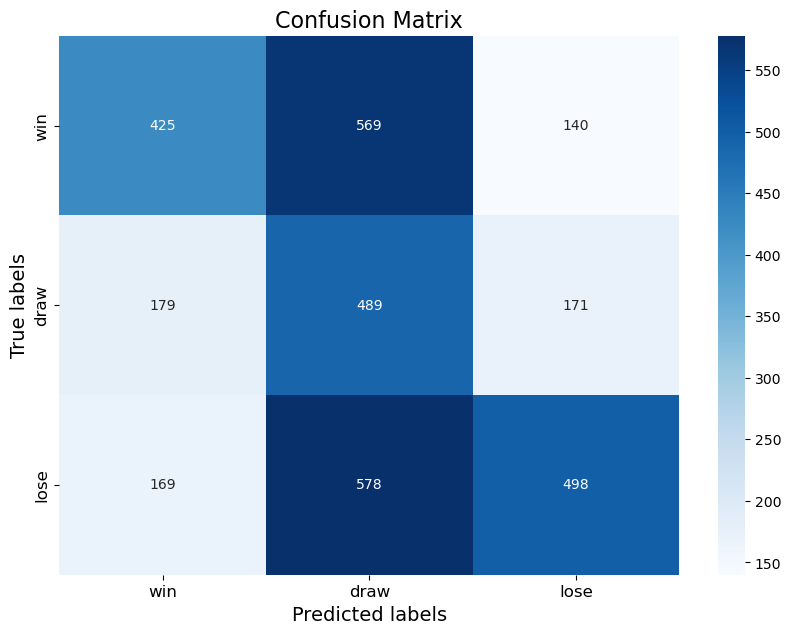

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

conf_matrix = confusion_matrix(y_test_outcomes, y_pred_outcomes, labels=["win", "draw", "lose"])

fig, ax = plt.subplots(figsize=(10, 7)) 
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax,
            xticklabels=["win", "draw", "lose"], yticklabels=["win", "draw", "lose"])

# Labels, title, and ticks
label_font = {'size':'14'}
ax.set_xlabel('Predicted labels', fontdict=label_font)
ax.set_ylabel('True labels', fontdict=label_font)
ax.set_title('Confusion Matrix', fontdict={'size':'16'}) 
ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

In [31]:
# Calculate the accuracy
accuracy = accuracy_score(y_test_outcomes, y_pred_outcomes)
print("Accuracy:", accuracy)

Accuracy: 0.4387818520820385


In [32]:
print("Classification Report:")
print(classification_report(y_test_outcomes, y_pred_outcomes, labels=['win', 'draw', 'lose']))

Classification Report:
              precision    recall  f1-score   support

         win       0.55      0.37      0.45      1134
        draw       0.30      0.58      0.40       839
        lose       0.62      0.40      0.48      1245

    accuracy                           0.44      3218
   macro avg       0.49      0.45      0.44      3218
weighted avg       0.51      0.44      0.45      3218



In [33]:
# model = Sequential()
# # Assuming M is the number of features after preprocessing and Dense layers
# model.add(Dense(64, activation='relu', input_shape=(38, M)))  # Dense layer example
# model.add(LSTM(128, return_sequences=False))  # LSTM layer
# model.add(Dense(3, activation='softmax'))  # Output layer for 3 classes: win/loss/draw

# model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [2]:
import json
from constants import TEAM_COLUMNS_DICT_COMBINED
print(json.dumps(TEAM_COLUMNS_DICT_COMBINED, indent=2))

{
  "meta": [
    "squad",
    "season_start_year",
    "season_end_year",
    "minutes_90s",
    "country",
    "squad_size",
    "foreigners",
    "squad_value_avg",
    "squad_value"
  ],
  "squad": [
    "players_used",
    "pens_made",
    "pens_att",
    "cards_yellow",
    "cards_red",
    "cards_yellow_red",
    "fouls",
    "fouled",
    "offsides",
    "own_goals"
  ],
  "gk": [
    "gk_goals_against_per90",
    "gk_save_pct",
    "gk_clean_sheets_pct",
    "gk_psxg",
    "gk_psnpxg_per_shot_on_target_against",
    "gk_psxg_net_per90",
    "gk_passes_pct_launched",
    "gk_pct_passes_launched",
    "gk_goal_kick_length_avg",
    "gk_crosses_stopped_pct",
    "gk_def_actions_outside_pen_area_per90",
    "gk_goals_against",
    "gk_shots_on_target_against",
    "gk_pens_saved",
    "gk_pens_missed",
    "gk_free_kick_goals_against",
    "gk_corner_kick_goals_against",
    "gk_psxg_net"
  ],
  "attack": [
    "goals_per90",
    "assists_per90",
    "goals_assists_per90",
    "go